In [1]:
import tensorflow as tf
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center_x': anno['center'][0],
        'center_y': anno['center'][1],
        'scale': anno['scale']
    }
    return annotation

In [3]:
with open('./mpii_human_pose_v1_u12_2/train.json') as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, './mpii/images/')
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

First train annotation:  {'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'filename': '015601864.jpg', 'scale': 3.021046, 'center_y': 257.0, 'filepath': './mpii/images/015601864.jpg', 'center_x': 594.0, 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


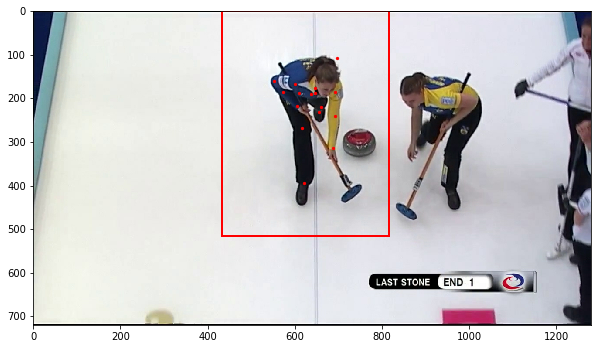

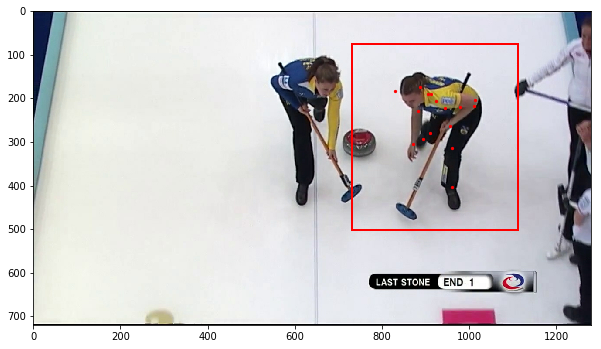

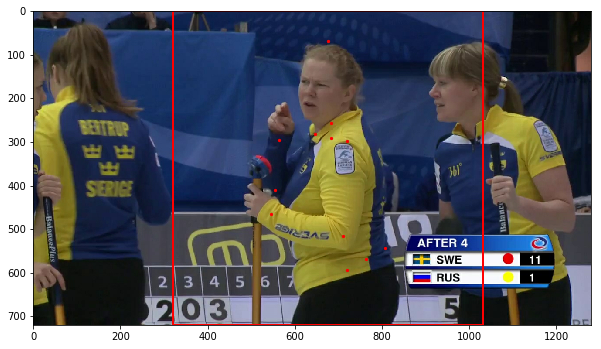

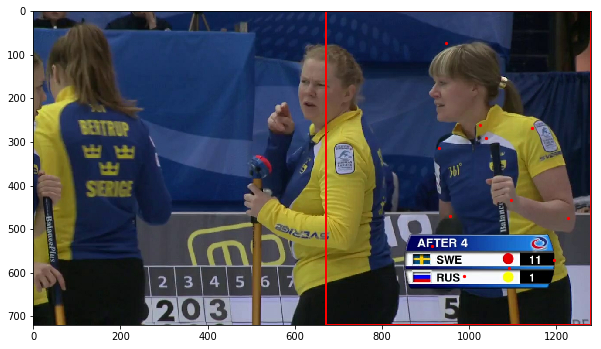

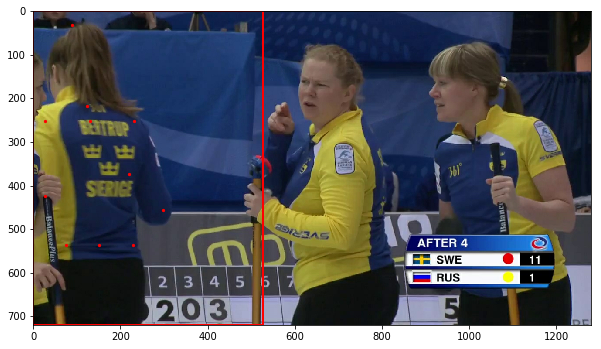

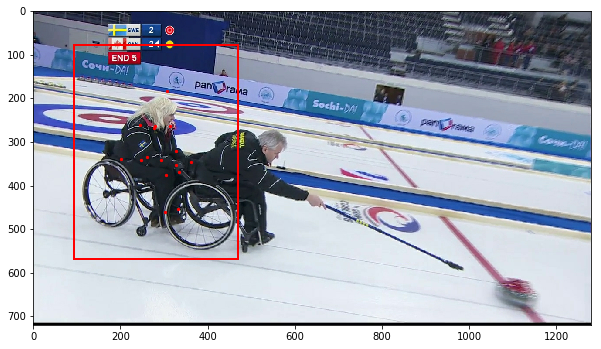

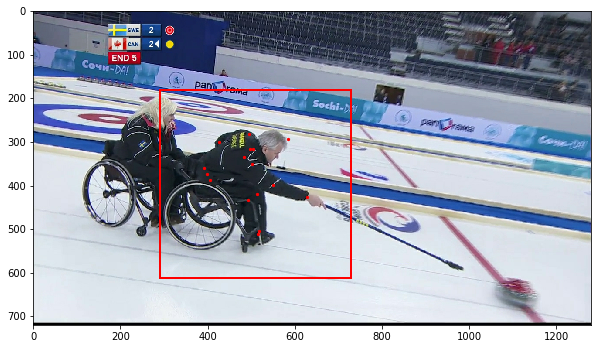

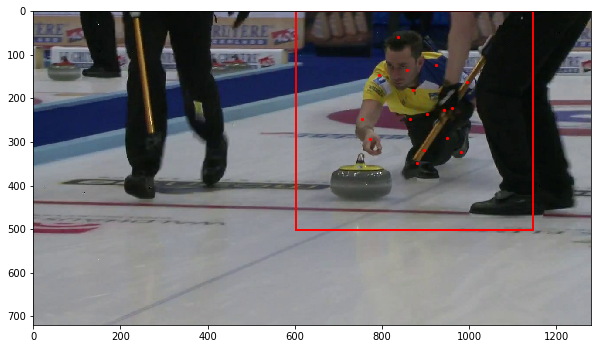

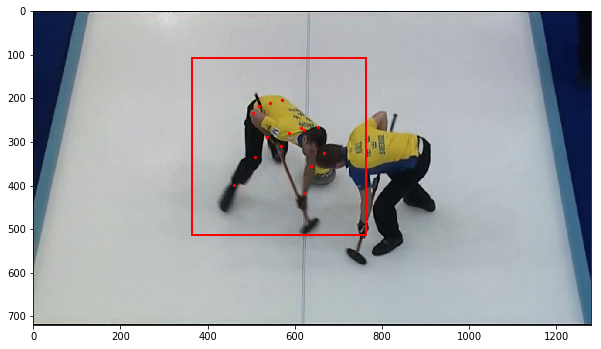

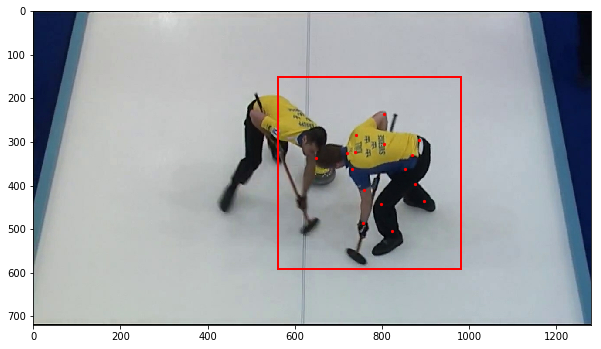

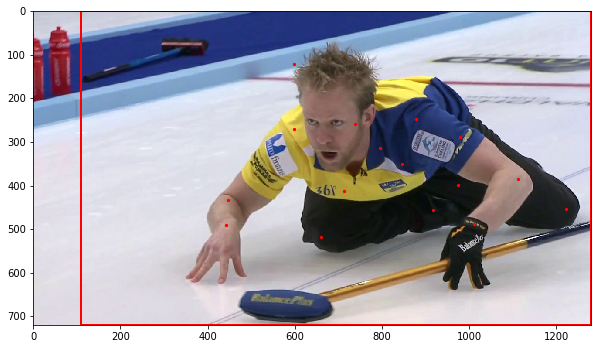

In [4]:
plt.rcParams['figure.figsize'] = (10,10)

n = 0
for anno in train_annotations:
    image = tf.io.decode_image(tf.io.read_file(anno['filepath']))
    img_height, img_width, img_depth = image.shape
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    
    joint_xmin = img_width
    joint_xmax = 0
    joint_ymin = img_height
    joint_ymax = 0
    for joint in anno['joints']:
        if joint[0] < 0 or joint[1] < 0:
            continue
        plt.scatter(joint[0], joint[1], s=5, c='red', marker='o')
        joint_xmin = joint[0] if joint[0] < joint_xmin else joint_xmin
        joint_xmax = joint[0] if joint[0] > joint_xmax else joint_xmax
        joint_ymin = joint[1] if joint[1] < joint_ymin else joint_ymin
        joint_ymax = joint[1] if joint[1] > joint_ymax else joint_ymax

    center_x = anno['center_x']
    center_y = anno['center_y']
    height = anno['scale'] * 200
    
    # Method 1: Crop based on joint location
    # Looks like this is the best method without cutting part of the body
    xmin = joint_xmin - 0.2 * height
    xmax = joint_xmax + 0.2 * height
    ymin = joint_ymin - 0.2 * height
    ymax = joint_ymax + 0.2 * height

    # Method 2: Crop based on height only
#     width = height
#     xmin = center_x - width / 2
#     ymin = center_y - height / 2
#     xmax = center_x + width / 2
#     ymax = center_y + height / 2
    
    # Method 3: Crop based on the average of height and joint location
#     if xmin < joint_xmin:
#         xmin = (xmin + joint_xmin) / 2
#     if xmax > joint_xmax:
#         xmax = (xmax + joint_xmax) / 2
#     if ymin < joint_ymin:
#         ymin = (ymin + joint_ymin) / 2
#     if ymax > joint_ymax:
#         ymax = (ymax + joint_ymax) / 2
    
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height

    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    rect = patches.Rectangle((effective_xmin,effective_ymin),effective_width,effective_height,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    n += 1
    if n > 10:
        break

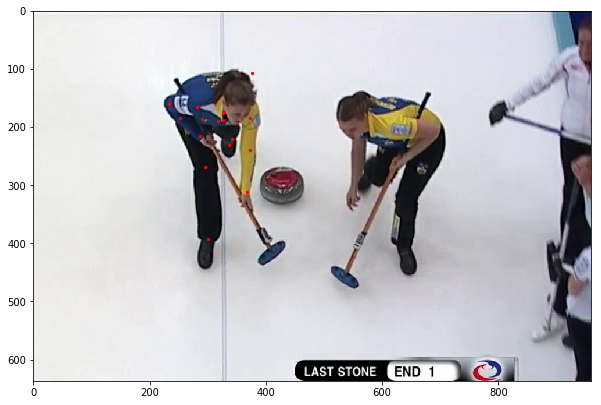

In [5]:
for anno in train_annotations:
    content = tf.io.read_file(anno['filepath'])
    image = tf.io.decode_image(content)
    img_height, img_width, img_depth = image.shape
    
    center_x = anno['center_x']
    center_y = anno['center_y']
    height = anno['scale'] * 200

    xmin = joint_xmin - 0.2 * height
    xmax = joint_xmax + 0.2 * height
    ymin = joint_ymin - 0.2 * height
    ymax = joint_ymax + 0.2 * height
    
    joint_xmin = img_width
    joint_xmax = 0
    joint_ymin = img_height
    joint_ymax = 0
    for joint in anno['joints']:
        if joint[0] < 0 or joint[1] < 0:
            continue
        joint_xmin = joint[0] if joint[0] < joint_xmin else joint_xmin
        joint_xmax = joint[0] if joint[0] > joint_xmax else joint_xmax
        joint_ymin = joint[1] if joint[1] < joint_ymin else joint_ymin
        joint_ymax = joint[1] if joint[1] > joint_ymax else joint_ymax
        
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    
    effective_xmin = tf.cast(effective_xmin, dtype=tf.int32)
    effective_ymin = tf.cast(effective_ymin, dtype=tf.int32)
    effective_xmax = tf.cast(effective_xmax, dtype=tf.int32)
    effective_ymax = tf.cast(effective_ymax, dtype=tf.int32)

    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin
    
    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_height, new_width, new_depth = image.shape
    
    encoded = tf.io.encode_jpeg(image, format='rgb', quality=100)
    
    effective_joints = []
    for joint in anno['joints']:
        if joint[0] < 0 or joint[1] < 0:
            effective_joints.append(joint)
        effective_joints.append((joint[0] - effective_xmin.numpy(), joint[1] - effective_ymin.numpy()))
        
    # draw it    
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    encoded = tf.io.encode_jpeg(image, format='rgb', quality=100)
    
    for joint in effective_joints:
        if joint[0] < 0 or joint[1] < 0:
            continue
        plt.scatter(joint[0], joint[1], s=5, c='red', marker='o')

    break

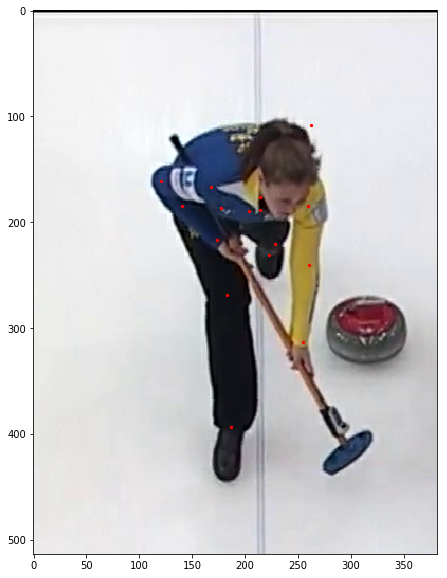

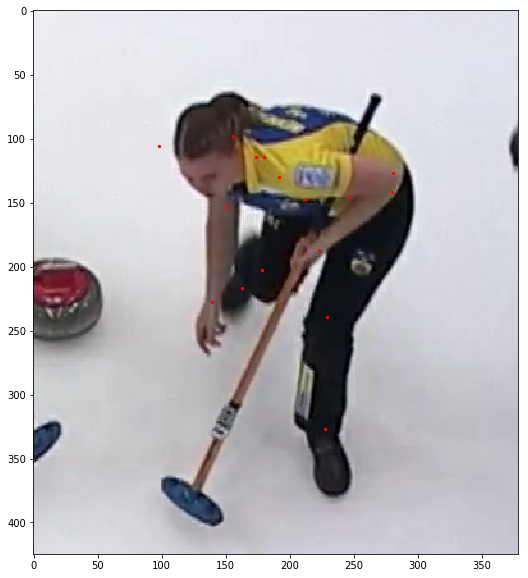

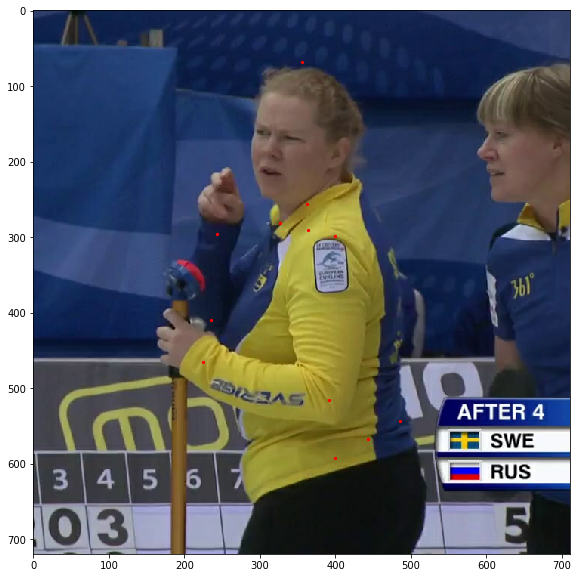

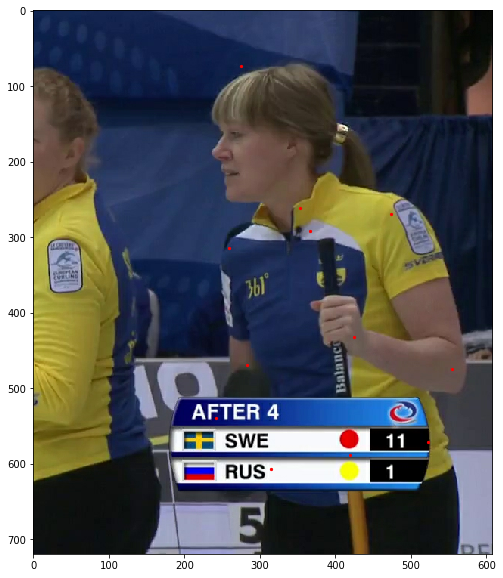

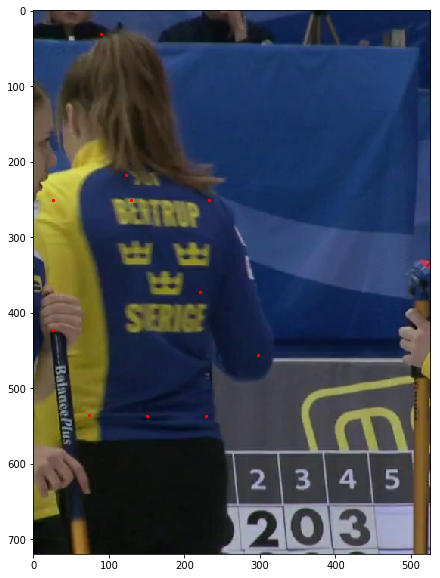

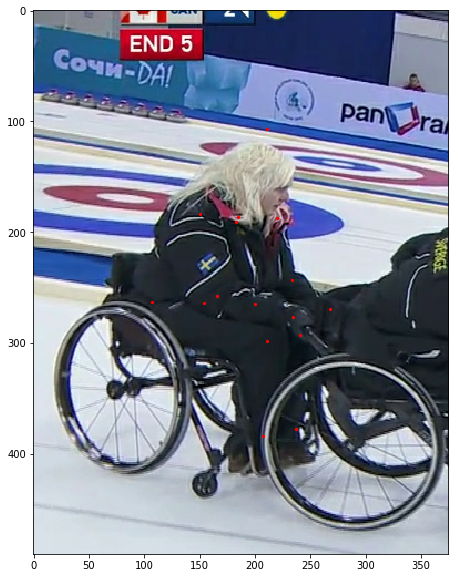

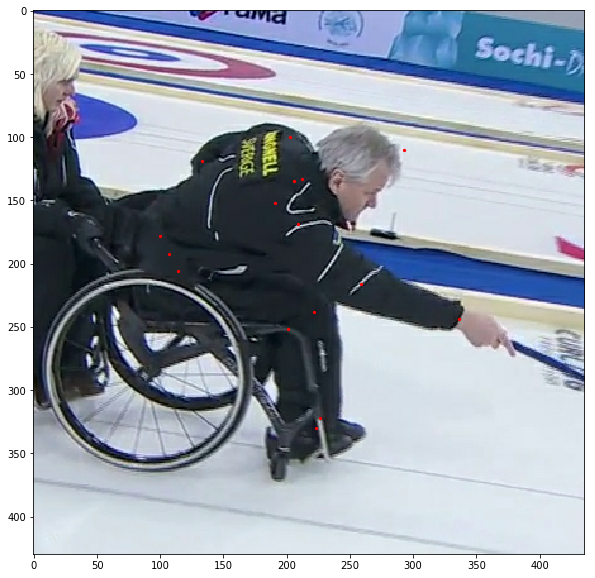

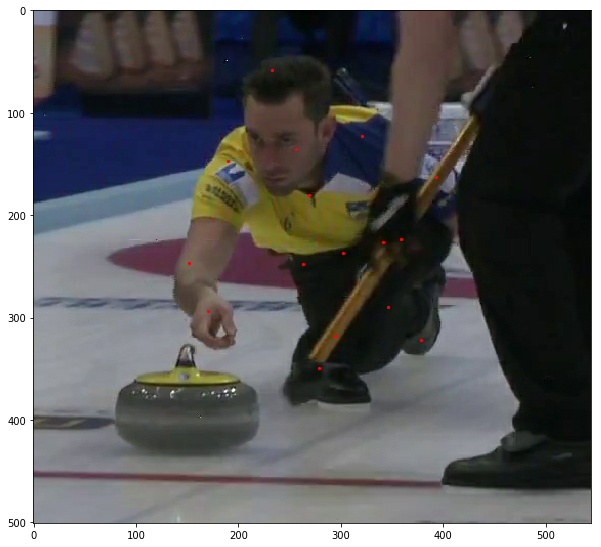

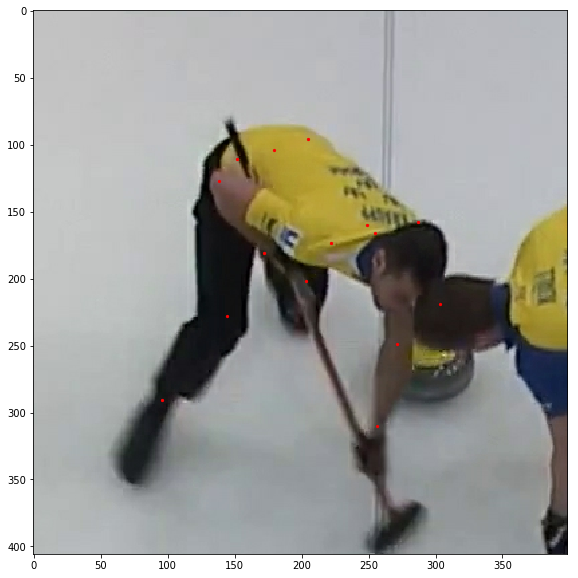

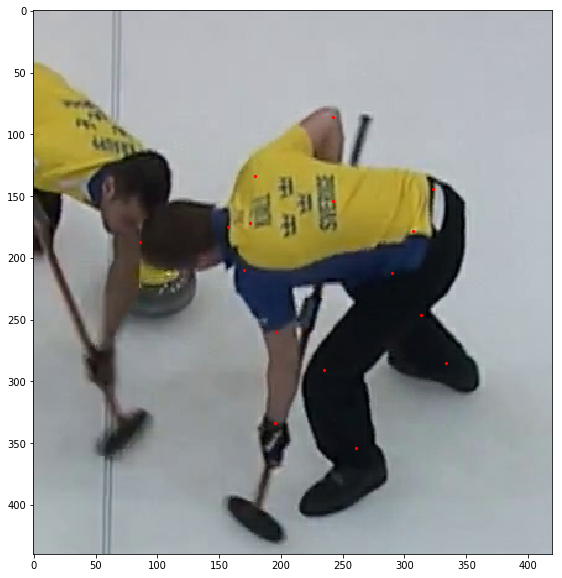

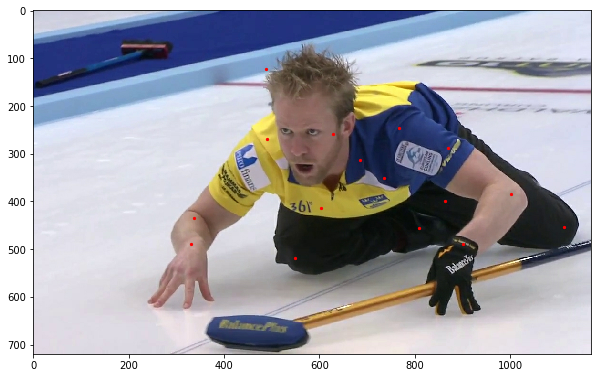

In [24]:
n = 0       
for anno in train_annotations:
    content = tf.io.read_file(anno['filepath'])
    image = tf.io.decode_image(content)
    features = {}

    keypoint_x = tf.cast(tf.convert_to_tensor([joint[0] for joint in anno['joints']]), dtype=tf.int32)
    keypoint_y = tf.cast(tf.convert_to_tensor([joint[1] for joint in anno['joints']]), dtype=tf.int32)
    center_x = tf.cast(tf.convert_to_tensor(anno['center_x']), dtype=tf.int32)
    center_y = tf.cast(tf.convert_to_tensor(anno['center_y']), dtype=tf.int32)
    body_height = tf.cast(tf.convert_to_tensor(anno['scale'] * 200), dtype=tf.int32)

    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

#     keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
#     keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
#     center_x = features['image/object/center/x']
#     center_y = features['image/object/center/y']
#     body_height = features['image/object/scale'] * 200
    
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x != -1)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y != -1)

    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    xmin = keypoint_xmin - tf.cast(body_height / 5, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height / 5, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height / 5, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height / 5, dtype=tf.int32)

    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height

    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin)
    effective_keypoint_y = (keypoint_y - effective_ymin)
    
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    encoded = tf.io.encode_jpeg(image, format='rgb', quality=100)

    for joint in zip(effective_keypoint_x, effective_keypoint_y):
        if joint[0] < 0 or joint[1] < 0:
            continue
        plt.scatter(joint[0].numpy(), joint[1].numpy(), s=5, c='red', marker='o')

    n += 1
    if n > 10:
        break